In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)
print(train_images.shape)

(60000, 28, 28, 1)


In [3]:
def create_generator():
    model = tf.keras.Sequential()

    # creating Dense layer with units 7*7*256(batch_size) and input_shape of (100,)
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


def create_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [4]:
noise_dim = 100
num_of_generated_examples = 16
BATCH_SIZE = 256

seed = tf.random.normal([num_of_generated_examples, noise_dim])
generator = create_generator()
discriminator = create_discriminator()
generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [5]:
@tf.function
def train_step(images, arg, epoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)
    
    if arg == 1:
        print("Epoch: {}\nGenerator Loss: {}\nDiscriminator Loss: {}".format(epoch+1, gen_loss, disc_loss))

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [6]:
import os

PROJECT_ROOT_DIR = "."
SAVE_ID = "picture"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, SAVE_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=100):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [7]:
import datetime

log_dir = ".\\log"
run_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"/"
train_file_writer = tf.summary.create_file_writer(log_dir+run_name+"/train")
val_file_writer = tf.summary.create_file_writer(log_dir+run_name+"/validation")

Epoch: 1
Generator Loss: 0.9547878503799438
Discriminator Loss: 1.3782458305358887
Time for epoch 1 is 18.51433277130127 sec
Epoch: 2
Generator Loss: 1.4063366651535034
Discriminator Loss: 0.8773062229156494
Time for epoch 2 is 17.84054136276245 sec
Epoch: 3
Generator Loss: 1.3328661918640137
Discriminator Loss: 0.9898360967636108
Time for epoch 3 is 17.925196409225464 sec
Epoch: 4
Generator Loss: 1.5184214115142822
Discriminator Loss: 0.8480625748634338
Time for epoch 4 is 18.215500354766846 sec
Epoch: 5
Generator Loss: 1.3009490966796875
Discriminator Loss: 0.8747352361679077
Time for epoch 5 is 18.01139259338379 sec
Generated Images after 5 epochs
Saving figure 5


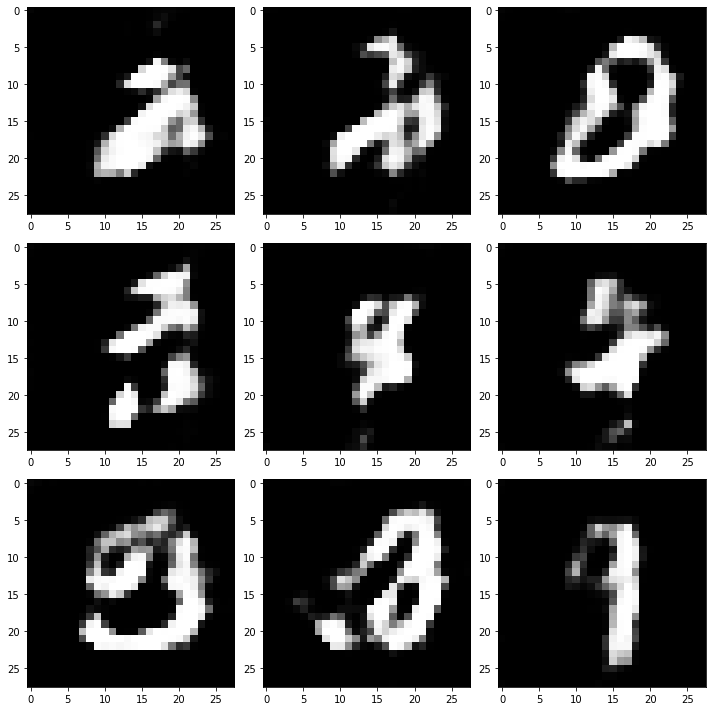

Epoch: 6
Generator Loss: 1.261506199836731
Discriminator Loss: 1.152797818183899
Time for epoch 6 is 17.333227157592773 sec
Epoch: 7
Generator Loss: 1.2729562520980835
Discriminator Loss: 0.9480535984039307
Time for epoch 7 is 17.202418565750122 sec
Epoch: 8
Generator Loss: 1.4236669540405273
Discriminator Loss: 1.1136047840118408
Time for epoch 8 is 17.381752490997314 sec
Epoch: 9
Generator Loss: 1.1893306970596313
Discriminator Loss: 1.2883777618408203
Time for epoch 9 is 17.980962991714478 sec
Epoch: 10
Generator Loss: 1.259770154953003
Discriminator Loss: 0.9319252967834473
Time for epoch 10 is 18.043226957321167 sec
Generated Images after 10 epochs
Saving figure 10


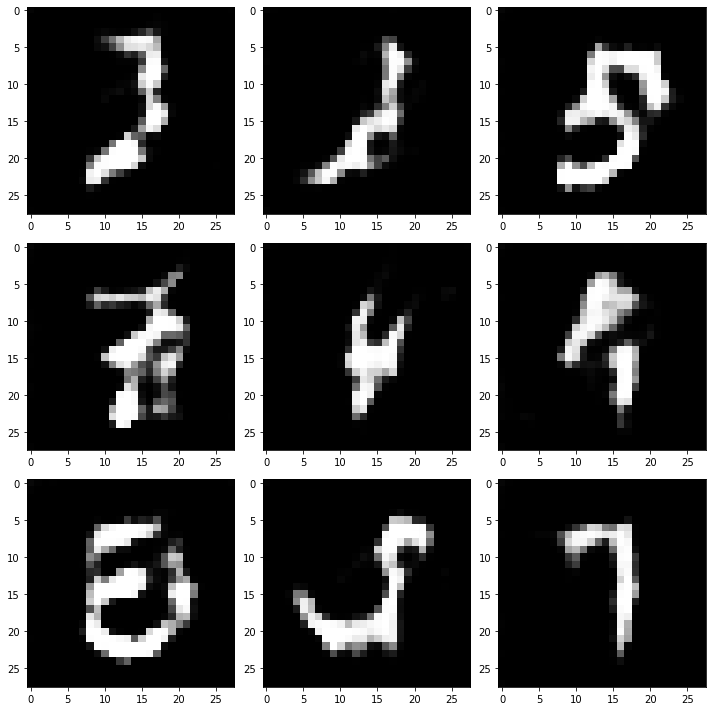

Epoch: 11
Generator Loss: 1.4079290628433228
Discriminator Loss: 0.8479945659637451
Time for epoch 11 is 17.397370100021362 sec
Epoch: 12
Generator Loss: 1.276195764541626
Discriminator Loss: 0.8836199045181274
Time for epoch 12 is 17.725265741348267 sec
Epoch: 13
Generator Loss: 1.194649338722229
Discriminator Loss: 1.0250940322875977
Time for epoch 13 is 17.835354566574097 sec
Epoch: 14
Generator Loss: 1.0338932275772095
Discriminator Loss: 1.3186286687850952
Time for epoch 14 is 17.189733028411865 sec
Epoch: 15
Generator Loss: 0.9917505383491516
Discriminator Loss: 1.2436237335205078
Time for epoch 15 is 17.73541283607483 sec
Generated Images after 15 epochs
Saving figure 15


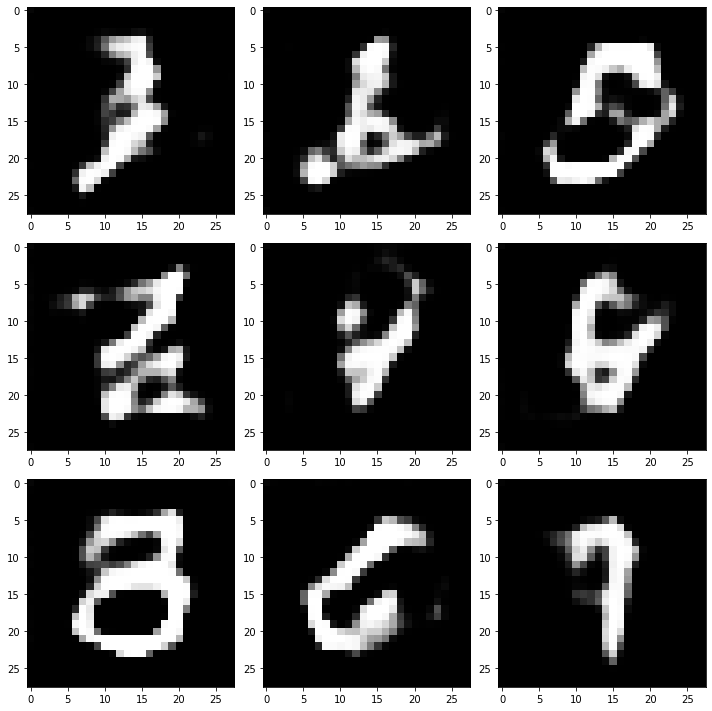

Epoch: 16
Generator Loss: 1.2932676076889038
Discriminator Loss: 0.9824783802032471
Time for epoch 16 is 17.66540241241455 sec
Epoch: 17
Generator Loss: 1.0703413486480713
Discriminator Loss: 1.1256647109985352
Time for epoch 17 is 17.340291261672974 sec
Epoch: 18
Generator Loss: 1.0711095333099365
Discriminator Loss: 1.2748925685882568
Time for epoch 18 is 17.459080696105957 sec
Epoch: 19
Generator Loss: 0.9409090280532837
Discriminator Loss: 1.260599136352539
Time for epoch 19 is 17.44359540939331 sec
Epoch: 20
Generator Loss: 1.022714614868164
Discriminator Loss: 1.2225794792175293
Time for epoch 20 is 17.391958236694336 sec
Generated Images after 20 epochs
Saving figure 20


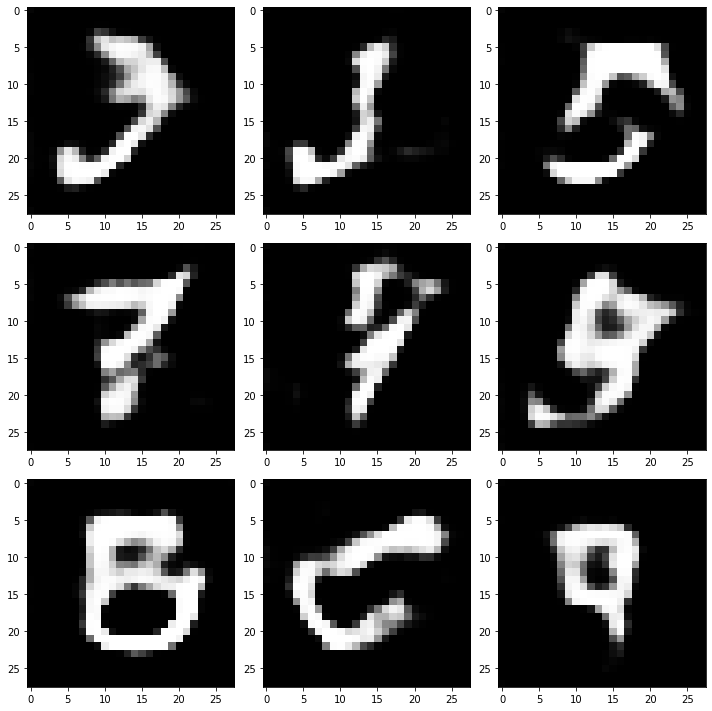

Epoch: 21
Generator Loss: 1.1317064762115479
Discriminator Loss: 1.2142462730407715
Time for epoch 21 is 17.448652267456055 sec
Epoch: 22
Generator Loss: 1.0148919820785522
Discriminator Loss: 1.1281914710998535
Time for epoch 22 is 17.289240837097168 sec
Epoch: 23
Generator Loss: 0.9311047792434692
Discriminator Loss: 1.337073564529419
Time for epoch 23 is 17.58158779144287 sec
Epoch: 24
Generator Loss: 0.9897831678390503
Discriminator Loss: 1.21773362159729
Time for epoch 24 is 17.362268924713135 sec
Epoch: 25
Generator Loss: 1.073702096939087
Discriminator Loss: 1.0353981256484985
Time for epoch 25 is 17.555781841278076 sec
Generated Images after 25 epochs
Saving figure 25


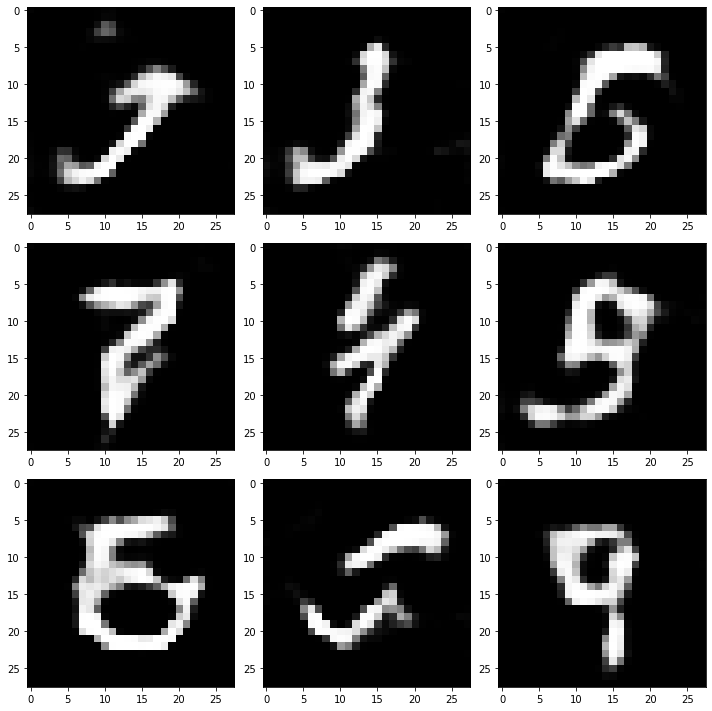

Epoch: 26
Generator Loss: 0.8709256052970886
Discriminator Loss: 1.333911657333374
Time for epoch 26 is 17.896266222000122 sec
Epoch: 27
Generator Loss: 0.8327693343162537
Discriminator Loss: 1.3968439102172852
Time for epoch 27 is 17.749321699142456 sec
Epoch: 28
Generator Loss: 0.9035129547119141
Discriminator Loss: 1.237731695175171
Time for epoch 28 is 17.505517959594727 sec
Epoch: 29
Generator Loss: 0.9425115585327148
Discriminator Loss: 1.2114070653915405
Time for epoch 29 is 17.640777111053467 sec
Epoch: 30
Generator Loss: 1.2326384782791138
Discriminator Loss: 1.0802302360534668
Time for epoch 30 is 17.249247074127197 sec
Generated Images after 30 epochs
Saving figure 30


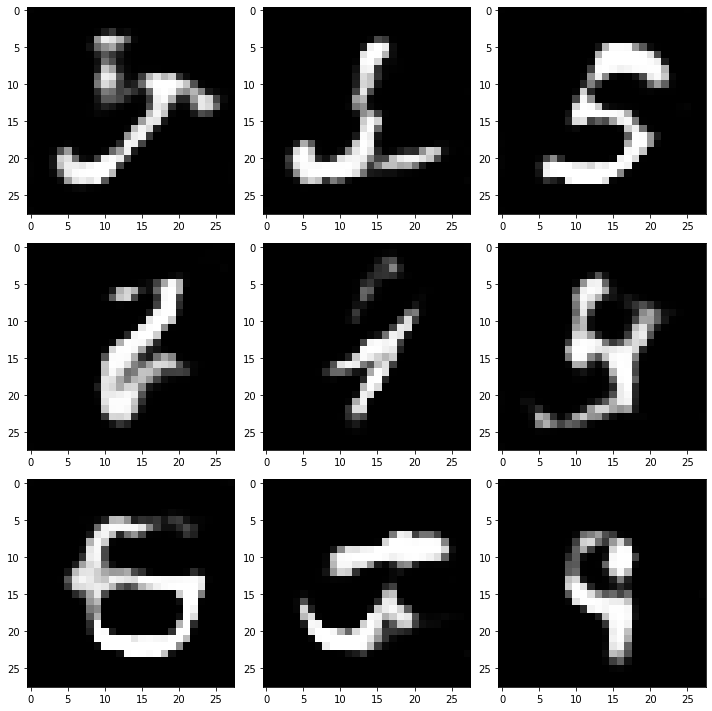

Epoch: 31
Generator Loss: 0.8497831225395203
Discriminator Loss: 1.2439842224121094
Time for epoch 31 is 17.40614891052246 sec
Epoch: 32
Generator Loss: 0.8290334939956665
Discriminator Loss: 1.2856923341751099
Time for epoch 32 is 16.99993395805359 sec
Epoch: 33
Generator Loss: 0.9734658002853394
Discriminator Loss: 1.1651442050933838
Time for epoch 33 is 17.342660903930664 sec
Epoch: 34
Generator Loss: 0.9831013679504395
Discriminator Loss: 1.2318322658538818
Time for epoch 34 is 17.79798936843872 sec
Epoch: 35
Generator Loss: 0.9346504211425781
Discriminator Loss: 1.1599550247192383
Time for epoch 35 is 17.35947346687317 sec
Generated Images after 35 epochs
Saving figure 35


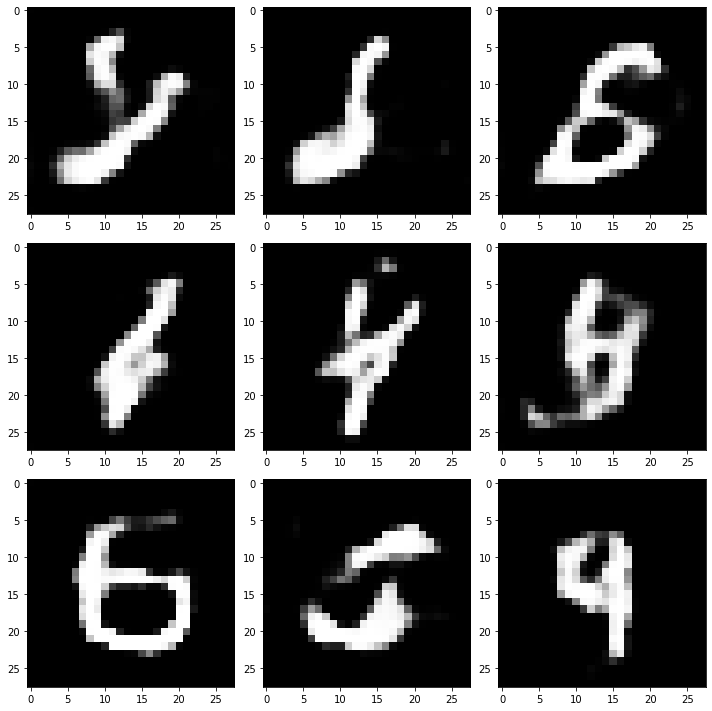

Epoch: 36
Generator Loss: 0.8286434412002563
Discriminator Loss: 1.1758501529693604
Time for epoch 36 is 16.80489993095398 sec
Epoch: 37
Generator Loss: 0.936702311038971
Discriminator Loss: 1.3335387706756592
Time for epoch 37 is 17.665557384490967 sec
Epoch: 38
Generator Loss: 0.9234799742698669
Discriminator Loss: 1.2262909412384033
Time for epoch 38 is 17.793028831481934 sec
Epoch: 39
Generator Loss: 0.9470173120498657
Discriminator Loss: 1.3226022720336914
Time for epoch 39 is 18.155109643936157 sec
Epoch: 40
Generator Loss: 0.9560538530349731
Discriminator Loss: 1.4386321306228638
Time for epoch 40 is 19.1733980178833 sec
Generated Images after 40 epochs
Saving figure 40


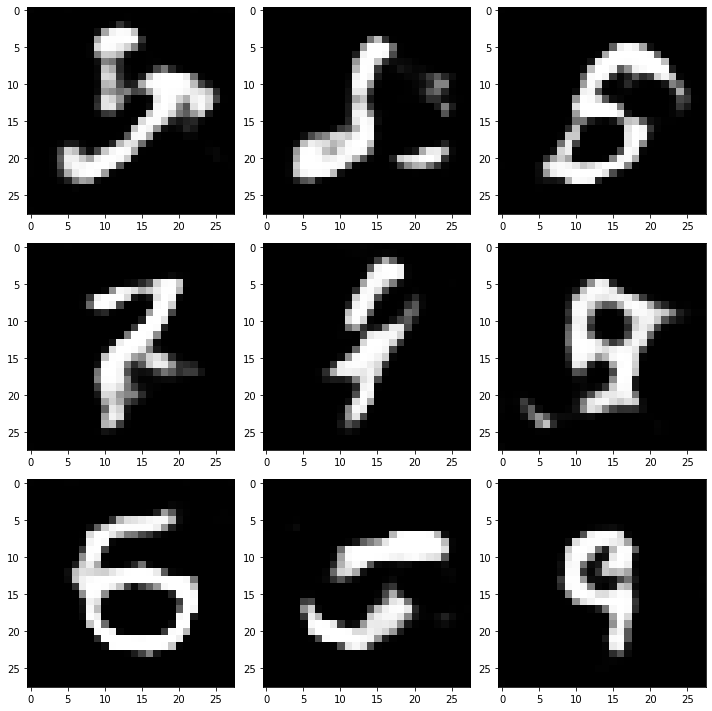

Epoch: 41
Generator Loss: 1.0117135047912598
Discriminator Loss: 1.3196802139282227
Time for epoch 41 is 18.4909029006958 sec
Epoch: 42
Generator Loss: 0.7994421720504761
Discriminator Loss: 1.375540852546692
Time for epoch 42 is 18.419973850250244 sec
Epoch: 43
Generator Loss: 0.9520346522331238
Discriminator Loss: 1.2598882913589478
Time for epoch 43 is 18.669864892959595 sec
Epoch: 44
Generator Loss: 0.8530964255332947
Discriminator Loss: 1.1282521486282349
Time for epoch 44 is 18.15682625770569 sec
Epoch: 45
Generator Loss: 1.0729811191558838
Discriminator Loss: 1.2227036952972412
Time for epoch 45 is 18.238438367843628 sec
Generated Images after 45 epochs
Saving figure 45


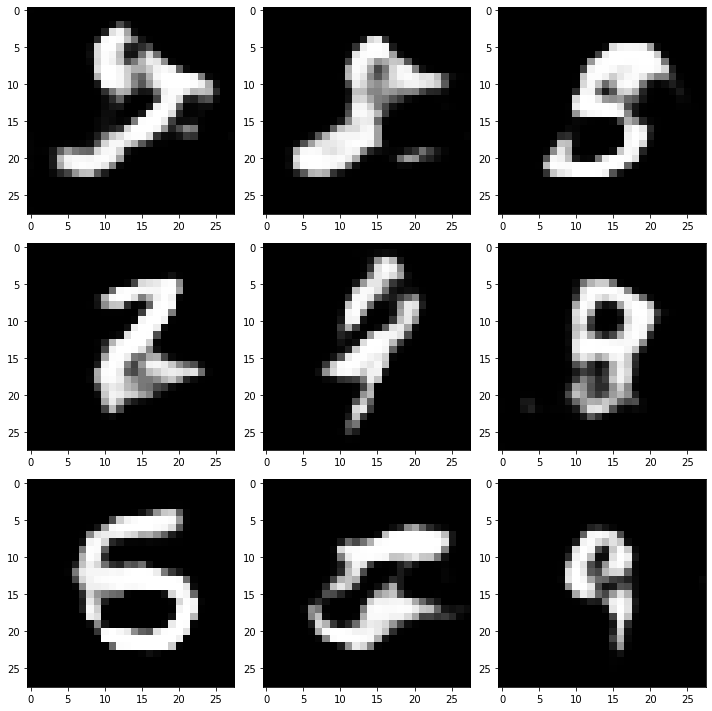

Epoch: 46
Generator Loss: 1.0208775997161865
Discriminator Loss: 1.3340013027191162
Time for epoch 46 is 18.2772798538208 sec
Epoch: 47
Generator Loss: 0.898547887802124
Discriminator Loss: 1.2534136772155762
Time for epoch 47 is 17.232786655426025 sec
Epoch: 48
Generator Loss: 0.9302382469177246
Discriminator Loss: 1.1154654026031494
Time for epoch 48 is 17.19962215423584 sec
Epoch: 49
Generator Loss: 0.91414874792099
Discriminator Loss: 1.1793897151947021
Time for epoch 49 is 16.91842818260193 sec
Epoch: 50
Generator Loss: 0.9438099265098572
Discriminator Loss: 1.2421586513519287
Time for epoch 50 is 17.57801628112793 sec
Generated Images after 50 epochs
Saving figure 50


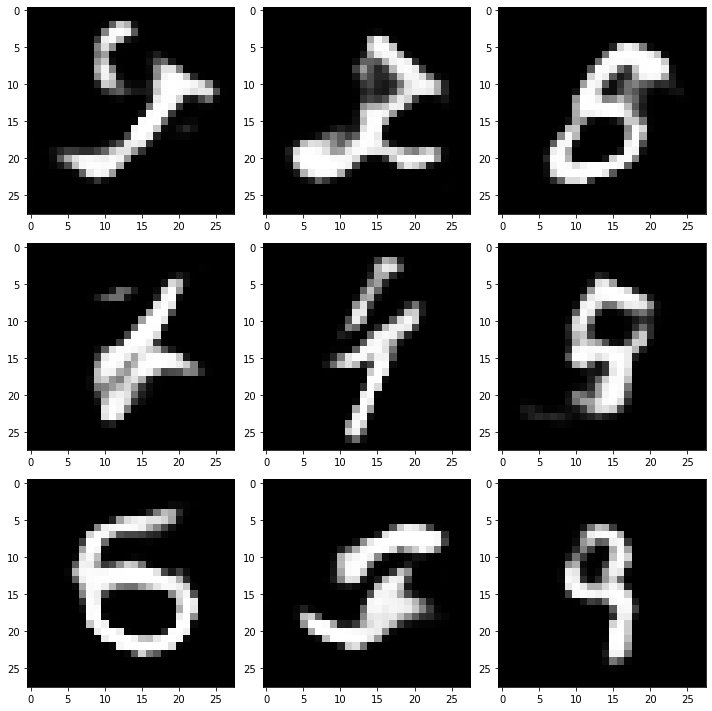

Epoch: 51
Generator Loss: 0.816461443901062
Discriminator Loss: 1.3353455066680908
Time for epoch 51 is 17.468083381652832 sec
Epoch: 52
Generator Loss: 0.8629269599914551
Discriminator Loss: 1.243733525276184
Time for epoch 52 is 17.167455911636353 sec
Epoch: 53
Generator Loss: 0.9036465883255005
Discriminator Loss: 1.2559454441070557
Time for epoch 53 is 17.252273321151733 sec
Epoch: 54
Generator Loss: 0.9355542659759521
Discriminator Loss: 1.1810026168823242
Time for epoch 54 is 17.645803928375244 sec
Epoch: 55
Generator Loss: 1.2199302911758423
Discriminator Loss: 1.1253398656845093
Time for epoch 55 is 17.740262746810913 sec
Generated Images after 55 epochs
Saving figure 55


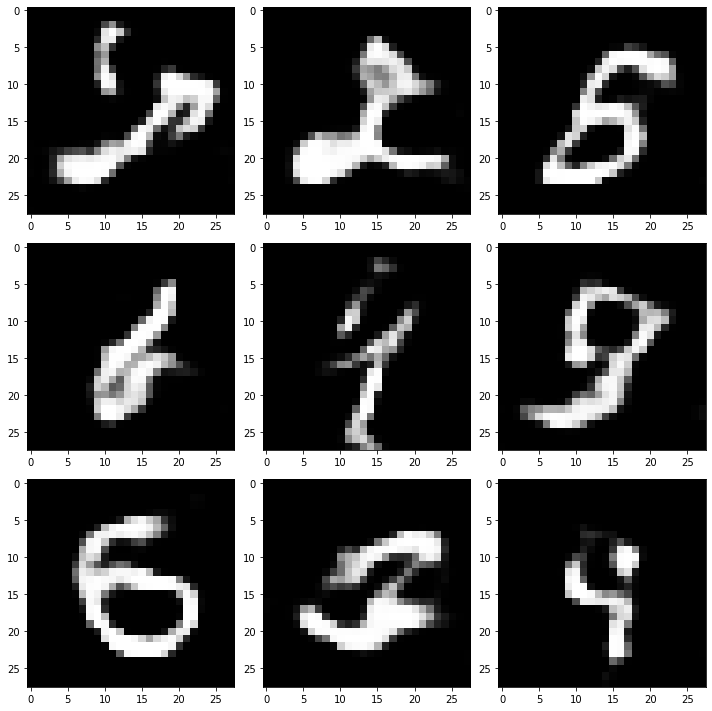

Epoch: 56
Generator Loss: 0.771759569644928
Discriminator Loss: 1.316164255142212
Time for epoch 56 is 17.35695791244507 sec
Epoch: 57
Generator Loss: 0.9952295422554016
Discriminator Loss: 1.1721299886703491
Time for epoch 57 is 17.388769388198853 sec
Epoch: 58
Generator Loss: 0.9974409937858582
Discriminator Loss: 1.2032923698425293
Time for epoch 58 is 17.760108947753906 sec
Epoch: 59
Generator Loss: 0.9355311989784241
Discriminator Loss: 1.2643617391586304
Time for epoch 59 is 17.58371639251709 sec
Epoch: 60
Generator Loss: 1.1138602495193481
Discriminator Loss: 1.124300479888916
Time for epoch 60 is 17.452773332595825 sec
Generated Images after 60 epochs
Saving figure 60


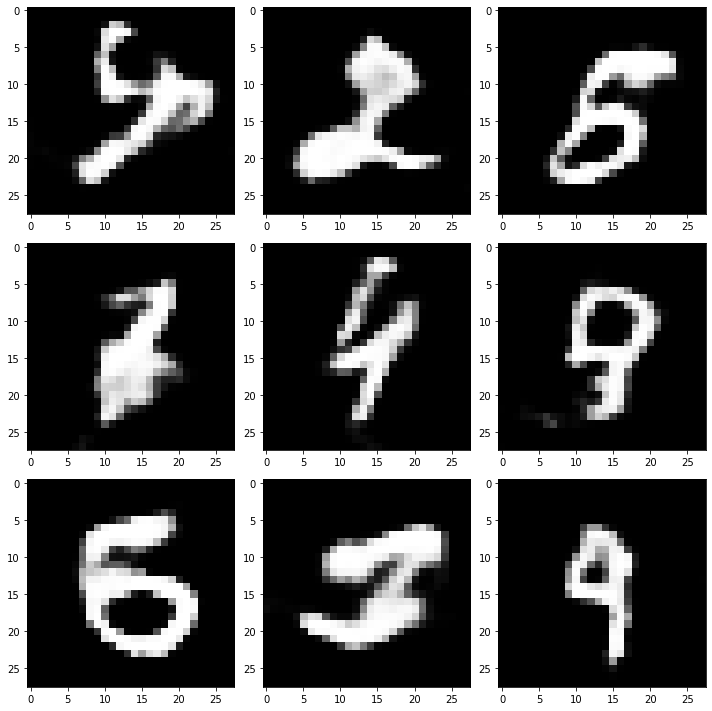

Epoch: 61
Generator Loss: 0.9522166848182678
Discriminator Loss: 1.2495689392089844
Time for epoch 61 is 17.386919736862183 sec
Epoch: 62
Generator Loss: 0.8449128866195679
Discriminator Loss: 1.3600304126739502
Time for epoch 62 is 17.499396324157715 sec
Epoch: 63
Generator Loss: 0.8050118684768677
Discriminator Loss: 1.2837166786193848
Time for epoch 63 is 17.481045484542847 sec
Epoch: 64
Generator Loss: 0.9482952952384949
Discriminator Loss: 1.2015023231506348
Time for epoch 64 is 17.166579484939575 sec
Epoch: 65
Generator Loss: 0.9539278745651245
Discriminator Loss: 1.261223554611206
Time for epoch 65 is 18.471062421798706 sec
Generated Images after 65 epochs
Saving figure 65


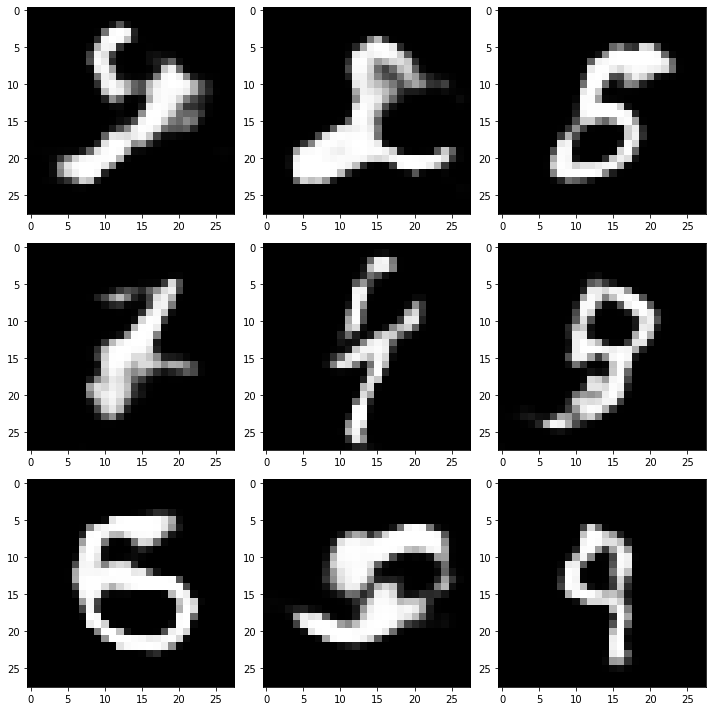

Epoch: 66
Generator Loss: 0.7709077596664429
Discriminator Loss: 1.4653372764587402
Time for epoch 66 is 18.243345260620117 sec
Epoch: 67
Generator Loss: 0.7610930800437927
Discriminator Loss: 1.365103006362915
Time for epoch 67 is 18.157878875732422 sec
Epoch: 68
Generator Loss: 0.8666353225708008
Discriminator Loss: 1.3364781141281128
Time for epoch 68 is 17.054980993270874 sec
Epoch: 69
Generator Loss: 0.7218598127365112
Discriminator Loss: 1.3777787685394287
Time for epoch 69 is 17.417556762695312 sec
Epoch: 70
Generator Loss: 0.7418149709701538
Discriminator Loss: 1.4683253765106201
Time for epoch 70 is 17.069790363311768 sec
Generated Images after 70 epochs
Saving figure 70


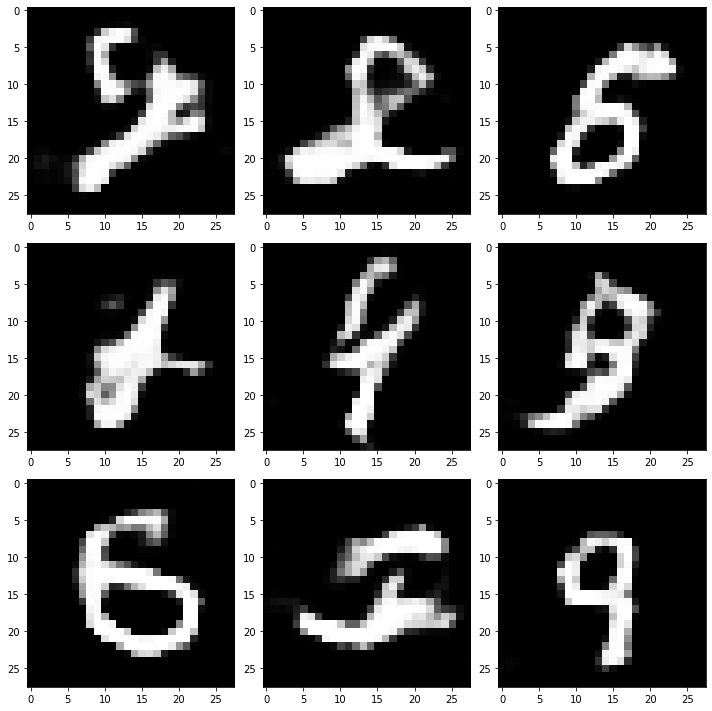

Epoch: 71
Generator Loss: 0.9246631264686584
Discriminator Loss: 1.424849510192871
Time for epoch 71 is 16.935829877853394 sec
Epoch: 72
Generator Loss: 0.9847016334533691
Discriminator Loss: 1.2052465677261353
Time for epoch 72 is 16.967189073562622 sec
Epoch: 73
Generator Loss: 0.8817663192749023
Discriminator Loss: 1.2811063528060913
Time for epoch 73 is 16.914122581481934 sec
Epoch: 74
Generator Loss: 0.9594235420227051
Discriminator Loss: 1.1202876567840576
Time for epoch 74 is 17.049027681350708 sec
Epoch: 75
Generator Loss: 0.8582882881164551
Discriminator Loss: 1.1617329120635986
Time for epoch 75 is 17.8971905708313 sec
Generated Images after 75 epochs
Saving figure 75


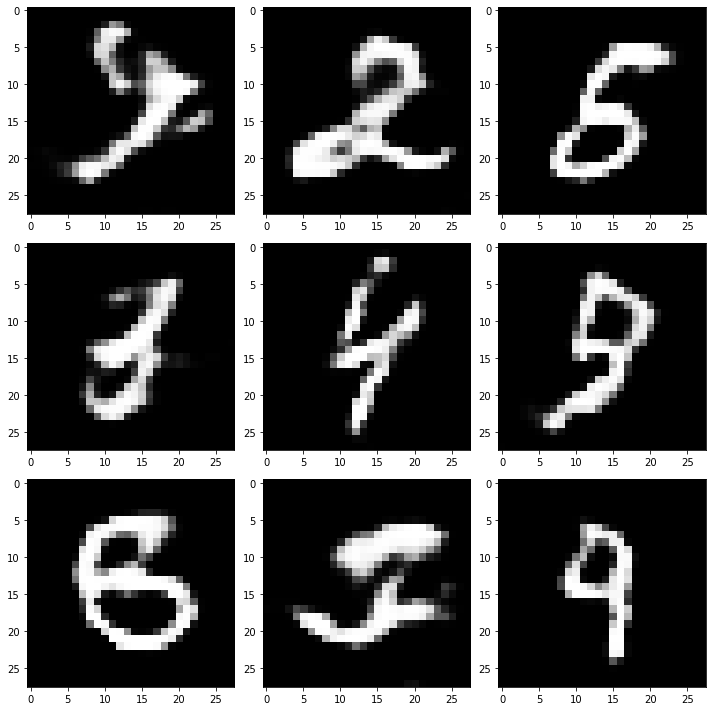

Epoch: 76
Generator Loss: 1.0833497047424316
Discriminator Loss: 1.199878454208374
Time for epoch 76 is 17.51923656463623 sec
Epoch: 77
Generator Loss: 0.9091804027557373
Discriminator Loss: 1.1956977844238281
Time for epoch 77 is 17.33394765853882 sec
Epoch: 78
Generator Loss: 0.933501124382019
Discriminator Loss: 1.1857938766479492
Time for epoch 78 is 17.401002168655396 sec
Epoch: 79
Generator Loss: 0.9443225860595703
Discriminator Loss: 1.2110671997070312
Time for epoch 79 is 17.582043647766113 sec
Epoch: 80
Generator Loss: 0.9129507541656494
Discriminator Loss: 1.2100918292999268
Time for epoch 80 is 17.899667978286743 sec
Generated Images after 80 epochs
Saving figure 80


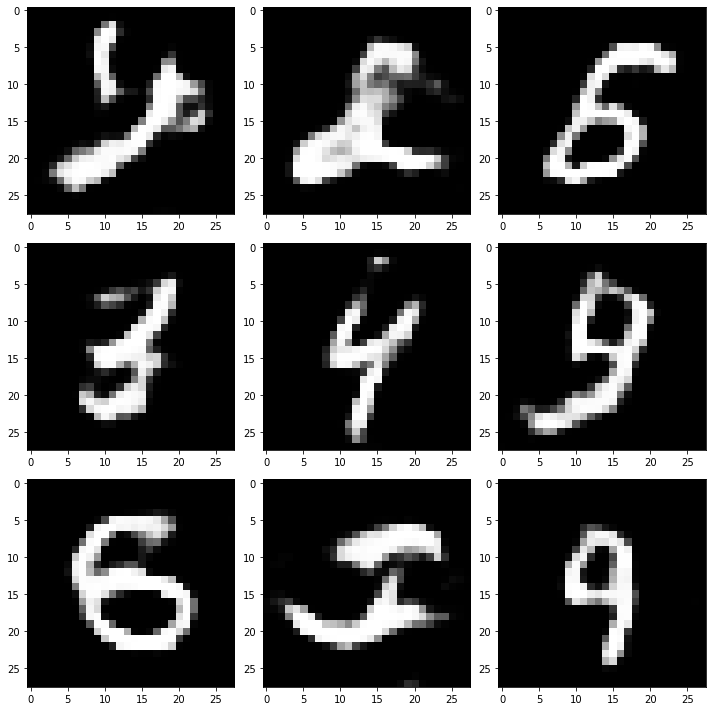

Epoch: 81
Generator Loss: 0.9372515678405762
Discriminator Loss: 1.3142807483673096
Time for epoch 81 is 18.252597093582153 sec
Epoch: 82
Generator Loss: 0.9587888717651367
Discriminator Loss: 1.225459337234497
Time for epoch 82 is 17.966134071350098 sec
Epoch: 83
Generator Loss: 0.9258401989936829
Discriminator Loss: 1.2753970623016357
Time for epoch 83 is 17.2422297000885 sec
Epoch: 84
Generator Loss: 0.9610702395439148
Discriminator Loss: 1.2471504211425781
Time for epoch 84 is 17.793525218963623 sec
Epoch: 85
Generator Loss: 0.901236891746521
Discriminator Loss: 1.2862887382507324
Time for epoch 85 is 17.861477613449097 sec
Generated Images after 85 epochs
Saving figure 85


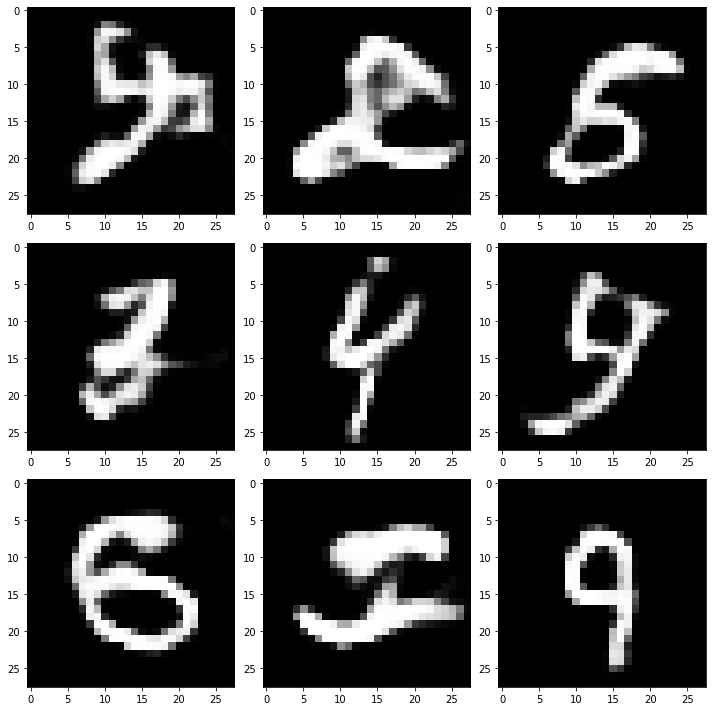

Epoch: 86
Generator Loss: 0.7915737628936768
Discriminator Loss: 1.3044931888580322
Time for epoch 86 is 18.06384587287903 sec
Epoch: 87
Generator Loss: 0.8832773566246033
Discriminator Loss: 1.2229197025299072
Time for epoch 87 is 17.679062128067017 sec
Epoch: 88
Generator Loss: 0.9630751609802246
Discriminator Loss: 1.2432992458343506
Time for epoch 88 is 18.92366099357605 sec
Epoch: 89
Generator Loss: 0.8940300941467285
Discriminator Loss: 1.3111224174499512
Time for epoch 89 is 17.723029375076294 sec
Epoch: 90
Generator Loss: 1.1614210605621338
Discriminator Loss: 1.0537452697753906
Time for epoch 90 is 17.468148231506348 sec
Generated Images after 90 epochs
Saving figure 90


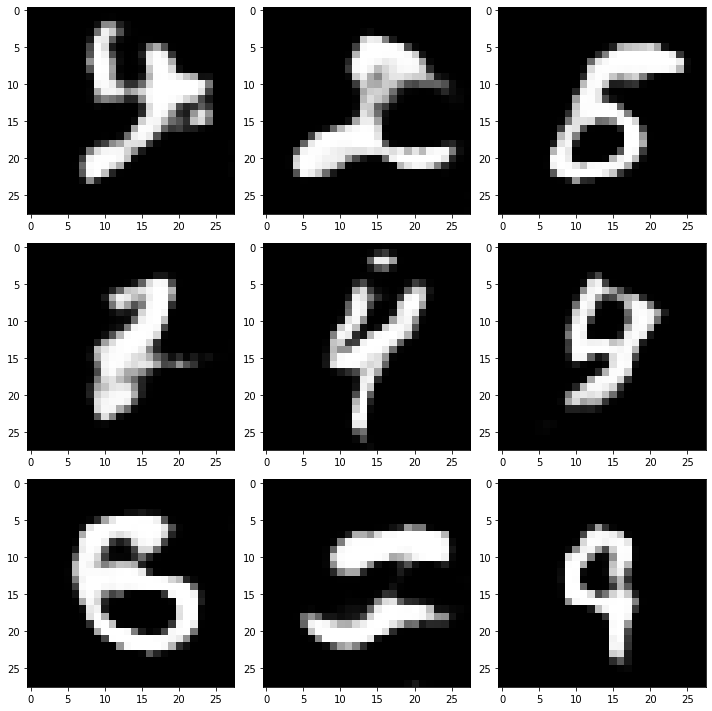

Epoch: 91
Generator Loss: 1.0114173889160156
Discriminator Loss: 1.1311993598937988
Time for epoch 91 is 17.599589347839355 sec
Epoch: 92
Generator Loss: 0.8869749307632446
Discriminator Loss: 1.2019031047821045
Time for epoch 92 is 17.653346300125122 sec
Epoch: 93
Generator Loss: 0.9221281409263611
Discriminator Loss: 1.1858887672424316
Time for epoch 93 is 17.460155487060547 sec
Epoch: 94
Generator Loss: 1.061547875404358
Discriminator Loss: 1.158592939376831
Time for epoch 94 is 17.90562152862549 sec
Epoch: 95
Generator Loss: 0.9822646975517273
Discriminator Loss: 1.2176885604858398
Time for epoch 95 is 17.90641951560974 sec
Generated Images after 95 epochs
Saving figure 95


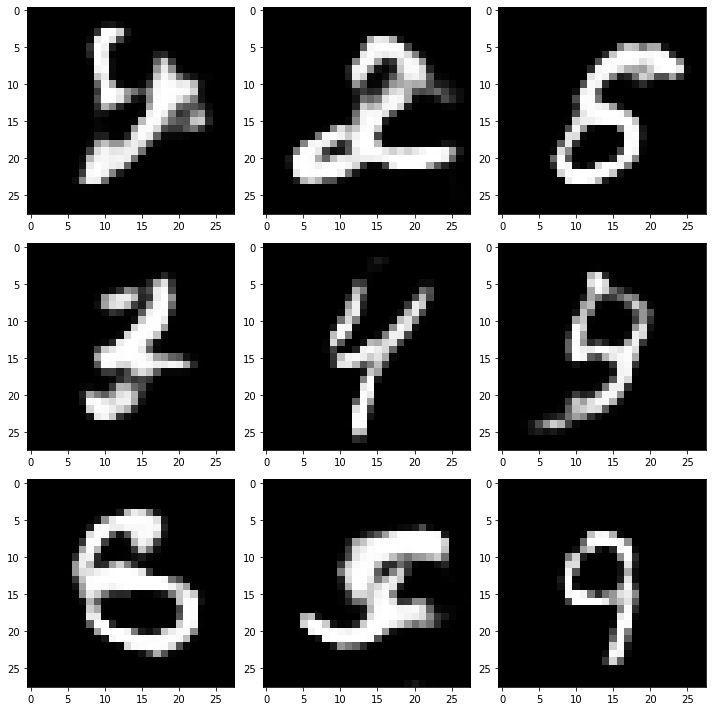

Epoch: 96
Generator Loss: 0.8706585168838501
Discriminator Loss: 1.3196470737457275
Time for epoch 96 is 17.80890130996704 sec
Epoch: 97
Generator Loss: 1.0911569595336914
Discriminator Loss: 1.1552640199661255
Time for epoch 97 is 17.507828950881958 sec
Epoch: 98
Generator Loss: 0.8943468332290649
Discriminator Loss: 1.2363377809524536
Time for epoch 98 is 17.587188482284546 sec
Epoch: 99
Generator Loss: 0.9109644293785095
Discriminator Loss: 1.2127580642700195
Time for epoch 99 is 17.88438606262207 sec
Epoch: 100
Generator Loss: 1.0239005088806152
Discriminator Loss: 1.115647792816162
Time for epoch 100 is 17.829237937927246 sec
Generated Images after 100 epochs
Saving figure 100


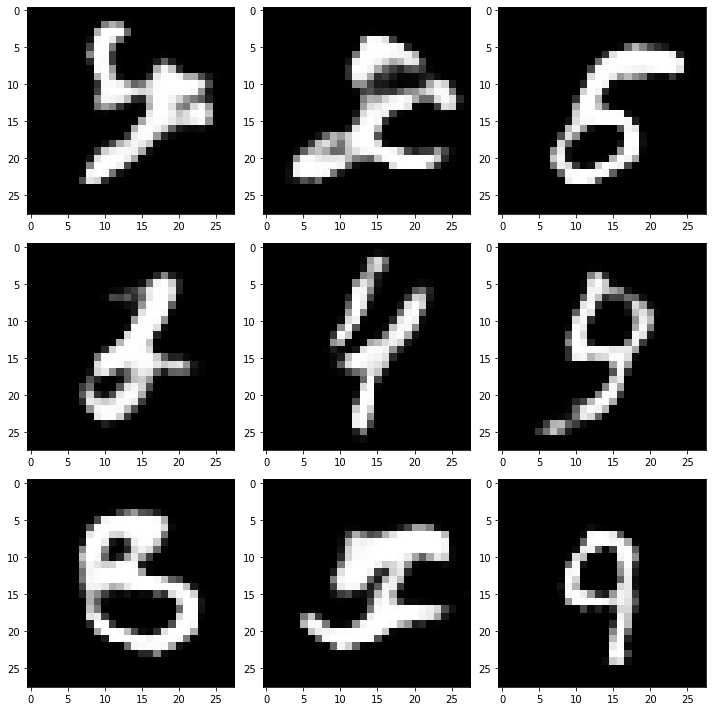

Epoch: 101
Generator Loss: 0.9473161697387695
Discriminator Loss: 1.308201789855957
Time for epoch 101 is 17.662863969802856 sec
Epoch: 102
Generator Loss: 0.896915078163147
Discriminator Loss: 1.372503399848938
Time for epoch 102 is 17.171284437179565 sec
Epoch: 103
Generator Loss: 0.9981527328491211
Discriminator Loss: 1.2015650272369385
Time for epoch 103 is 17.019267797470093 sec
Epoch: 104
Generator Loss: 0.9252886772155762
Discriminator Loss: 1.2322499752044678
Time for epoch 104 is 16.874666929244995 sec
Epoch: 105
Generator Loss: 0.9279671907424927
Discriminator Loss: 1.1653869152069092
Time for epoch 105 is 17.023968935012817 sec
Generated Images after 105 epochs
Saving figure 105


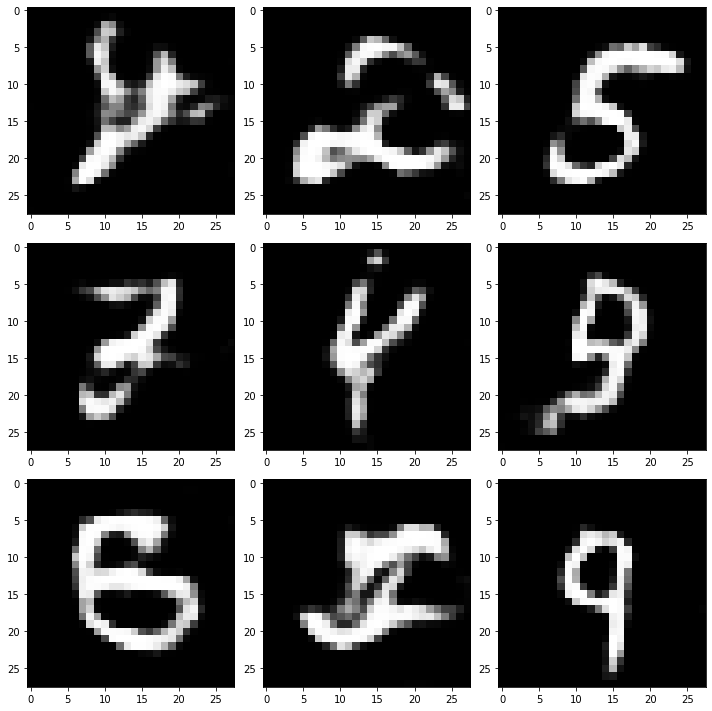

Epoch: 106
Generator Loss: 0.8782994747161865
Discriminator Loss: 1.277496337890625
Time for epoch 106 is 17.13967275619507 sec
Epoch: 107
Generator Loss: 0.8718277812004089
Discriminator Loss: 1.306426763534546
Time for epoch 107 is 17.29356575012207 sec
Epoch: 108
Generator Loss: 0.922614574432373
Discriminator Loss: 1.1937994956970215
Time for epoch 108 is 17.4261212348938 sec
Epoch: 109
Generator Loss: 0.9503427743911743
Discriminator Loss: 1.200377345085144
Time for epoch 109 is 17.59723663330078 sec


KeyboardInterrupt: 

In [12]:
def train_GAN(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        count = 0


        for image_batch in dataset:
            count += 1
            if count == 235:
                train_step(image_batch, 1, epoch)
            else:
                train_step(image_batch, 0, epoch)


        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
        generated_images = generator(seed, training=False)
        if (epoch + 1) % 5 == 0:
            print('Generated Images after {} epochs'.format(epoch + 1))
            plt.figure(figsize=(10, 10))
            for i in range(generated_images.shape[0]):
                if i < 9:
                    plt.subplot(3, 3, i + 1)
                    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
                    plt.axis('on')
            save_fig(str(epoch + 1))
            plt.show()


tf.config.run_functions_eagerly(True)
train_GAN(train_dataset, 600)